In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.metrics import accuracy_score, f1_score

# SVM

In [2]:
data0 = pd.read_csv("newdata3.csv", engine='python')
data1 = pd.read_csv("imputed_dataset_1.csv", engine='python')
data1.head()
data2 = pd.read_csv("imputed_dataset_2.csv", engine='python')
data2.head()
data3 = pd.read_csv("imputed_dataset_3.csv", engine='python')
data3.head()
data4 = pd.read_csv("imputed_dataset_4.csv", engine='python')
data4.head()
data5 = pd.read_csv("imputed_dataset_5.csv", engine='python')

In [3]:
data5.head()

,Unnamed: 0,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
2,2,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
3,3,49.812426,160.224186,0.0,0.0,1.0,2.0,1.0,2.0,0.0,...,3.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
4,4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0


1. Train an SVM (with a specific Kernel), plot the training and validation learning curves. You may need to subsample the dataset if SVM training is taking too long. Do you see any signs of overfitting? Interpret and discuss your results. (1 mark)
2. What are your results in the testing dataset? Interpret and discuss your results. (2 marks)
3. How sensitive is this method to different hyperparameters? For example the different types of kernel (e.g. linear, RBF, etc.). Make use of plots (e.g. performance on test dataset as a function of different hyperparameters) to help you discuss this point. (5 marks)
4. Plot decision boundaries and discuss their relevance. (2 marks)

## Prepare the data:

Separate target from data.

In [4]:
X = data5.drop(['has_dep_diag'],axis=1).drop(['secd_diag'],axis=1).drop(['prim_diag'],axis=1).drop(['dep_score'],axis=1).drop(['dep_thoughts'],axis=1).drop(['panic_score'], axis=1)
print(X.shape)
Y = np.column_stack((data5['has_dep_diag'], data5['secd_diag'], data5['prim_diag'], data5['dep_score'], data5['dep_thoughts']))
print(Y.shape)

(13734, 37)
(13734, 5)


Randomly shuffle the dataset.

In [5]:
from random import shuffle

def shuffle_dataset(N, X, y, X_shuffled, y_shuffled):
    ind_list = [i for i in range(N)]
    shuffle(ind_list)
    X_shuffled  = X.iloc[ind_list]
    y_shuffled = y.iloc[ind_list]

In [6]:
X_shuffled = X
y_shuffled = Y
shuffle_dataset(13734, pd. DataFrame(X), pd. DataFrame(Y), pd. DataFrame(X_shuffled), pd. DataFrame(y_shuffled))

Train-test split.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled,test_size=0.3, random_state=40)
print(X_train.shape); print(X_test.shape)
print(y_train.shape); print(y_test.shape)

(9613, 37)
(4121, 37)
(9613, 5)
(4121, 5)


Reduce the dataset.

In [8]:
X_train_reduced, y_train_reduced = X_train[0:400], y_train[0:400]
X_test_reduced, y_test_reduced = X_test[0:200], y_test[0:200]
print(X_train_reduced.shape); print(X_test_reduced.shape)
print(y_train_reduced.shape); print(y_test_reduced.shape)

(400, 37)
(200, 37)
(400, 5)
(200, 5)


In [9]:
from collections import Counter
Counter(y_train_reduced[:,0])

Counter({0.0: 381, 1.0: 19})

## Train model:
Imputed dataset 5, for has_dep_diag 

In [10]:
from sklearn import svm
from sklearn.svm import SVC

Basic SVM, with accuracy and f1-score:

In [11]:
##imbalanced
svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm.fit(X_train, y_train[:,0])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.9679600540934151
SVM classifier accuracy - test set: 0.9694248968696918
0.5075785697844445
0.500048142100074


In [12]:
##auto balancing
svm = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm.fit(X_train, y_train[:,0])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.6780401539581816
SVM classifier accuracy - test set: 0.6704683329289007
0.45348099565527067
0.4413915706425828


For diff hyperparameters: here the train set accuracy is lower than the test one as it should be.

In [13]:
svm = SVC(C=1, gamma = 'auto')
svm.fit(X_train, y_train[:,0])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.9849162592322896
SVM classifier accuracy - test set: 0.9728221305508372
0.8197476647055819
0.49311193111931123


All the other targets:

In [14]:
svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm.fit(X_train, y_train[:,1])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,1])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,1])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,1], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,1], average = "macro"))

SVM classifier accuracy: 0.7261000728180589
SVM classifier accuracy - test set: 0.7260373695704926
0.14368923833108113
0.17886816235287073


In [ ]:
svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm.fit(X_train, y_train[:,2])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,2])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,2])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,2], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,2], average = "macro"))

In [ ]:
svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm.fit(X_train, y_train[:,3])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,3])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,3])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,3], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,3], average = "macro"))

In [11]:
svm = SVC(C=0.1, gamma='scale', kernel='linear')
svm.fit(X_train_reduced, y_train_reduced[:,4])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,4])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,4])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,4], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,4], average = "macro"))

SVM classifier accuracy: 0.6736710704254655
SVM classifier accuracy - test set: 0.6804173744236836
0.30282341202585145
0.3014654117695467


## Exploration:

In [13]:
from sklearn.model_selection import learning_curve

#plot learning curve function from the labs
def plot_learning_curve(n, est, xs, ys, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator = est, X = xs, y = ys, cv = n)

    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', label='Training Accuracy')
    plt.plot(train_sizes, valid_mean, color='green', label='Validation Accuracy')

    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()


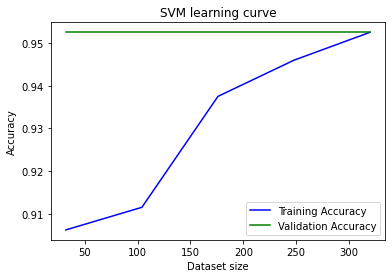

In [17]:
plot_learning_curve(5, SVC(C = 0.1, gamma = 'scale', kernel = 'rbf'),X_train_reduced, y_train_reduced[:,0], 'SVM learning curve')

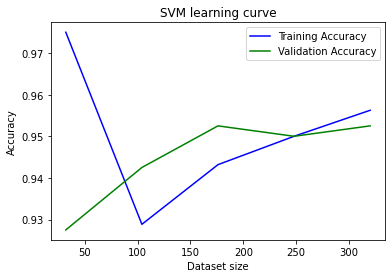

In [18]:
plot_learning_curve(5, SVC(C = 0.1, gamma = 'scale', kernel = 'linear'),X_train_reduced, y_train_reduced[:,0], 'SVM learning curve')

In [19]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(est, X, y, p_name, p_range, title):
    train_scores, test_scores = validation_curve(estimator=est,
                                             X=X, y=y,
                                             cv=5,
    param_name=p_name, param_range=p_range)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(p_range, train_mean,
             color='blue', label='Training Accuracy')
    plt.plot(p_range, test_mean,
             color='green', label='Validation Accuracy')
    plt.xlabel(p_name)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.grid()
    plt.show()

In [21]:
plot_validation_curve(SVC(C = 0.1, kernel= 'linear', gamma = 'scale'), X_train_reduced, y_train_reduced[:,0], 'C', list(np.arange(0.0, 10, 0.1))
, "SVM validation curve")

KeyboardInterrupt: 

## Tune hypermarameters:

In [25]:
##on accuracy
import time
from sklearn.model_selection import GridSearchCV

start = time.perf_counter()

param_grid = {
    'C': [0.1,1, 5, 10, 100], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'sigmoid']
}
tuned_svm = GridSearchCV(SVC(), param_grid, cv = 5, scoring='accuracy', verbose = 2, n_jobs=-1)
tuned_svm.fit(X_train_reduced, y_train_reduced[:,0])

end = time.perf_counter()

params = tuned_svm.best_params_

print(params)
print(tuned_svm.score(X_train,y_train[:,0]))
print(tuned_svm.score(X_test,y_test[:,0]))
y_pred = tuned_svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = tuned_svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))
print(str((end - start)) + ' mins')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.9710808280453552
0.9728221305508372
0.492664133417775
0.49311193111931123
0.17924579999998969 mins


In [28]:
## on f1 macro
from sklearn.model_selection import GridSearchCV

start = time.perf_counter()

param_grid = {
    'C': [0.1,1, 5, 10, 100], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'sigmoid']
}
tuned_svm = GridSearchCV(SVC(), param_grid, cv = 5, scoring='f1_macro' , verbose = 2, n_jobs=-1)
tuned_svm.fit(X_train_reduced, y_train_reduced[:,0])

end = time.perf_counter()

params = tuned_svm.best_params_

print(params)
print(tuned_svm.score(X_train,y_train[:,0]))
print(tuned_svm.score(X_test,y_test[:,0]))
y_pred = tuned_svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = tuned_svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))


print(str((end - start)) + ' mins')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.492664133417775
0.49311193111931123
0.492664133417775
0.49311193111931123
0.19644419999985985 mins


## NuSVC

In [29]:
from sklearn.svm import NuSVC
## the largst nu I was allowed
svm = NuSVC(nu = 0.05)
svm.fit(X_train, y_train[:,0])

print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,0])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,0])}')
y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,0], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,0], average = "macro"))

SVM classifier accuracy: 0.6491209820035369
SVM classifier accuracy - test set: 0.6277602523659306
0.42074505122893324
0.40795109725853945


## On normalized data:

In [30]:
from sklearn import preprocessing

normalized_data = preprocessing.normalize(X_shuffled)
normalized_target = preprocessing.normalize(y_shuffled)
print(normalized_data[0,:])
print(normalized_target[0,:])

[0.         0.31011812 0.94981285 0.         0.         0.00523017
 0.00523017 0.00523017 0.01046033 0.         0.00523017 0.01046033
 0.00523017 0.         0.00523017 0.01046033 0.01046033 0.00523017
 0.         0.         0.00523017 0.01046033 0.         0.00523017
 0.01046033 0.00523017 0.         0.00523017 0.01046033 0.01046033
 0.00523017 0.         0.00261508 0.00261508 0.02092066 0.
 0.00523017]
[0. 0. 0. 0. 1.]


In [31]:
from sklearn.model_selection import train_test_split

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(normalized_data, y_shuffled,test_size=0.3, random_state=40)
print(X_train_norm.shape); print(X_test_norm.shape)
print(y_train_norm.shape); print(y_test_norm.shape)
X_train_reduced_norm, y_train_reduced_norm = X_train_norm[0:400], y_train_norm[0:400]
X_test_reduced_norm, y_test_reduced_norm = X_test_norm[0:200], y_test_norm[0:200]
print(X_train_reduced_norm.shape); print(X_test_reduced_norm.shape)
print(y_train_reduced_norm.shape); print(y_test_reduced_norm.shape)

(9613, 37)
(4121, 37)
(9613, 5)
(4121, 5)
(400, 37)
(200, 37)
(400, 5)
(200, 5)


In [ ]:
##imbalanced
svm_norm = SVC(C=0.1, gamma='scale', kernel='linear')
svm_norm.fit(X_train_norm, y_train_norm[:,0])
print(f'SVM classifier accuracy: {svm_norm.score(X_train_norm, y_train_norm[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_norm.score(X_test_norm, y_test_norm[:,0])}')

y_pred_norm = svm_norm.predict(X_train_norm)
print(f1_score(y_pred_norm, y_train_norm[:,0], average = "macro"))
y_pred_test_norm = svm_norm.predict(X_test_norm)
print(f1_score(y_pred_test_norm, y_test_norm[:,0], average = "macro"))

In [ ]:
##auto balancing
##has_dep_diag
svm_norm = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm_norm.fit(X_train_norm, y_train_norm[:,0])
print(f'SVM classifier accuracy: {svm_norm.score(X_train_norm, y_train_norm[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_norm.score(X_test_norm, y_test_norm[:,0])}')

y_pred_norm = svm_norm.predict(X_train_norm)
print(f1_score(y_pred_norm, y_train_norm[:,0], average = "macro"))
y_pred_test_norm = svm_norm.predict(X_test_norm)
print(f1_score(y_pred_test_norm, y_test_norm[:,0], average = "macro"))

In [ ]:
##auto balancing
##secd_diag
svm = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm.fit(X_train, y_train[:,1])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,1])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,1])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,1], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,1], average = "macro"))

In [ ]:
##auto balancing
##prim_diag
svm = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm.fit(X_train, y_train[:,2])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,2])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,2])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,2], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,2], average = "macro"))

In [ ]:
##auto balancing
##dep_score
svm = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm.fit(X_train, y_train[:,3])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,3])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,3])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,3], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,3], average = "macro"))

In [ ]:
##auto balancing
##dep_thoughts
svm = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm.fit(X_train, y_train[:,4])
print(f'SVM classifier accuracy: {svm.score(X_train, y_train[:,4])}')
print(f'SVM classifier accuracy - test set: {svm.score(X_test, y_test[:,4])}')

y_pred = svm.predict(X_train)
print(f1_score(y_pred, y_train[:,4], average = "macro"))
y_pred_test = svm.predict(X_test)
print(f1_score(y_pred_test, y_test[:,4], average = "macro"))

## Random over and undersampling:

## Decision Boundaries

SVC on the deataset with reduced dimensionality (PCA)

In [32]:
#non-normalized
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_reduced)
X_test_pca = pca.fit_transform(X_test_reduced)

svm_pca = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm_pca.fit(X_pca, y_train_reduced[:,0])
print(f'SVM classifier accuracy: {svm_pca.score(X_pca, y_train_reduced[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_pca.score(X_test_pca, y_test_reduced[:,0])}')
y_pred = svm_pca.predict(X_pca)
print(f1_score(y_pred, y_train_reduced[:,0], average = "macro"))
y_pred_test = svm_pca.predict(X_test_pca)
print(f1_score(y_pred_test, y_test_reduced[:,0], average = "macro"))

SVM classifier accuracy: 0.9525
SVM classifier accuracy - test set: 0.98
0.48783610755441736
0.494949494949495


In [33]:
#normalized
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_reduced_norm)
X_test_pca = pca.fit_transform(X_test_reduced_norm)

svm_pca = SVC(C=0.1, gamma='scale', kernel='linear', class_weight = 'balanced')
svm_pca.fit(X_pca, y_train_reduced_norm[:,0])
print(f'SVM classifier accuracy: {svm_pca.score(X_pca, y_train_reduced_norm[:,0])}')
print(f'SVM classifier accuracy - test set: {svm_pca.score(X_test_pca, y_test_reduced_norm[:,0])}')
y_pred = svm_pca.predict(X_pca)
print(f1_score(y_pred, y_train_reduced_norm[:,0], average = "macro"))
y_pred_test = svm_pca.predict(X_test_pca)
print(f1_score(y_pred_test, y_test_reduced_norm[:,0], average = "macro"))

SVM classifier accuracy: 0.9525
SVM classifier accuracy - test set: 0.98
0.48783610755441736
0.494949494949495


In [34]:
from matplotlib.colors import ListedColormap
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = {0.0:'red', 1.0:'green'}  
    print(Z.shape)
    print(Z.ravel().shape)
    print(X[:, 0].shape)
    print(X[:, 1].shape)
    
    colored_labels = np.array([colors[xi] for xi in y]) #Z.ravel()
    plt.contourf(xx, yy, Z, cmap='viridis')


    cb = plt.colorbar()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=colored_labels, cmap='viridis', s=10)

    plt.show()

(25, 34)
(850,)
(400,)
(400,)


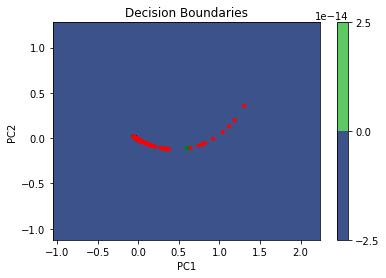

In [35]:
##can break the whole notebook on the non-normalized PCA
plot_decision_boundaries(X_pca, y_train_reduced[:,0], svm_pca, 'Decision Boundaries')


## ROC Curves

In [36]:
import sklearn.metrics as metrics
preds = svm_norm.predict(X_test_reduced_norm)
fpr, tpr, threshold = metrics.roc_curve(y_test_reduced[:,0], preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: name 'svm_norm' is not defined

In [ ]:
import sklearn.metrics as metrics
preds = svm.predict(X_test_reduced)
fpr, tpr, threshold = metrics.roc_curve(y_test_reduced[:,0], preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()